# **Part1. Text modeling using Berts**

## **1. Setting GPU, load data and bert embedding**

1.   parameters setting and GPU path sets
2.   load developement and temporal set
3.   tokenizer - embedding
4.   dataloader for training, val, test and temp 



In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Phd_thesis_xiaoli/project/older_nlp/'

import sys
import os

py_file_location = path
sys.path.append(os.path.abspath(py_file_location))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


para_all = {'bert': 'clinicalbert', # clinical_longformer, clinical_bigbird, bert
       'seq_len': 120, # 60, 120, 240
       'token_max_length': 512, # 256, 512
       'batch_size': 12, # 12, 16 
       'epochs': 2, # 1, 2, 3, 4
       'learning_rate': 1e-5} # 1e-5, 2e-5, 2e-5


save_name = 'max_len-'+str(para_all['token_max_length'])+'_bs-'\
+str(para_all['batch_size'])+'_epoch-'+str(para_all['epochs'])+'_lr-'+str(para_all['learning_rate'])


result_path = path + 'result/' + para_all['bert'] + '/seq_' + str(para_all['seq_len']) + '/' + save_name + '/'
if not os.path.exists(result_path):
    os.makedirs(result_path)

#print('para_all:', para_all)
#print('save_name:', save_name)
#print('result_path:', result_path)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd


df, df_development, df_temporal, id_source_info = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame
df_development = pd.read_csv(path+'data/seq_'+str(para_all['seq_len'])+'/development_text_older.csv')
df_temporal = pd.read_csv(path+'data/seq_'+str(para_all['seq_len'])+'/temporal_text_older.csv')

df = df_development.append(df_temporal).reset_index(drop=True)
id_source_info = pd.DataFrame({'id':list(df_development['id'].unique()), 'source':['development'] * len(list(df_development['id'].unique()))})
id_source_info = id_source_info.append(\
            pd.DataFrame({'id':list(df_temporal['id'].unique()), 'source':['temporal'] * len(list(df_temporal['id'].unique()))})
            )
id_source_info.reset_index(drop=True, inplace=True)

print('Number of development sentences: {:,}\n'.format(df_development.shape[0]))
print('Number of temporal sentences: {:,}\n'.format(df_temporal.shape[0]))
print('Number of total sentences: {:,}\n'.format(df.shape[0]))
print('Number of total patients: {:,}\n'.format(id_source_info.shape[0]))

df.sample(5)

del df_development, df_temporal

Number of development sentences: 91,761

Number of temporal sentences: 10,625

Number of total sentences: 102,386

Number of total patients: 29,474



In [6]:
df.shape

(102386, 3)

In [ ]:

df.rename(columns={'text': 'sentence'}, inplace=True)

df = df[['id','sentence', 'label']]

df.head(5)

,id,sentence,label
0,200014,family history: noncontributory. history of th...,0
1,200014,read as having left lower lobe pneumonia. at t...,0
2,200014,"which was concerning for pelvic fluid leak, po...",0
3,200014,daughter are both involved in his care. he has...,0
4,200019,chief complaint: left-sided weakness family hi...,1


In [ ]:

sentences = df.sentence.values
labels = df.label.values
id_all = df.id.values

In [ ]:
print('Loading BERT tokenizer...')

from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer

if para_all['bert'] == 'clinicalbert':
  tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
elif para_all['bert'] == 'clinical_longformer':
  tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-Longformer")
elif para_all['bert'] == 'clinical_bigbird':
  tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-BigBird")
else:
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  
# other models
# tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-Longformer")
# tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-BigBird")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Sample case

print(' Original: ', sentences[0])

print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print(len(tokenizer.tokenize(sentences[0])))

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  family history: noncontributory. history of the present illness: mr. is an 84-year-old male with a past medical history of myocardial infarction, severe copd, cvas times two, amyloid angiopathy. he is a nursing home resident with dementia. he was transferred from to of abdominal aortic aneurysm felt to be expanding and possibly leaking at the time of his transfer. the patient initially presented to the with hypercarbic respiratory acidosis secondary to copd. he was intubated. status post intubation, he had a decreased blood pressure to 55/ he was placed on empiric coverage of antibiotics. the white count was 6, hematocrit 9, temperature maximum of a chest x-ray at the time was read as having left lower lobe pneumonia. at the time,
Tokenized:  ['family', 'history', ':', 'non', '##con', '##tri', '##but', '##ory', '.', 'history', 'of', 'the', 'present', 'illness', ':', 'm', '##r', '.', 'is', 'an', '84', '-', 'year', '-', 'old', 'male', 'with', 'a', 'past', 'medical', 'history'

In [ ]:

import statistics

max_len = 0
len_list = []
for sent in sentences:

 
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
    len_list = len_list + [len(input_ids)]

print('Max sentence length: ', max_len)
print('Median sentence length: ', statistics.median(len_list))

Max sentence length:  447
Median sentence length:  189.0


In [ ]:

input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True,           
                        max_length = para_all['token_max_length'],    
                        pad_to_max_length = True,
                        return_attention_mask = True,          .
                        return_tensors = 'pt',             
                   )
    
    
    input_ids.append(encoded_dict['input_ids'])
    
    
    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
id_all = torch.tensor(id_all)

print('input_id shape: ', input_ids.shape)
print('attention_masks shape: ', attention_masks.shape)
print('labels shape: ', labels.shape)
print('id_all shape: ', id_all.shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


input_id shape:  torch.Size([102386, 512])
attention_masks shape:  torch.Size([102386, 512])
labels shape:  torch.Size([102386])
id_all shape:  torch.Size([102386])


In [ ]:

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Attention masks:', attention_masks[0])

Original:  family history: noncontributory. history of the present illness: mr. is an 84-year-old male with a past medical history of myocardial infarction, severe copd, cvas times two, amyloid angiopathy. he is a nursing home resident with dementia. he was transferred from to of abdominal aortic aneurysm felt to be expanding and possibly leaking at the time of his transfer. the patient initially presented to the with hypercarbic respiratory acidosis secondary to copd. he was intubated. status post intubation, he had a decreased blood pressure to 55/ he was placed on empiric coverage of antibiotics. the white count was 6, hematocrit 9, temperature maximum of a chest x-ray at the time was read as having left lower lobe pneumonia. at the time,
Token IDs: tensor([  101,  1266,  1607,   131,  1664,  7235, 19091, 16442,  4649,   119,
         1607,  1104,  1103,  1675,  6946,   131,   182,  1197,   119,  1110,
         1126,  5731,   118,  1214,   118,  1385,  2581,  1114,   170,  1763,
   

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

def get_tensordataset(input_ids, attention_masks, labels, id_all, id_source_info)
  # tensor to numpy
  input_ids_new = input_ids.numpy()
  attention_masks_new = attention_masks.numpy()
  labels_new = labels.numpy()
  id_all_new = id_all.numpy()

  # get train, val, test, temp id
  id_unique, id_train, id_val_test, id_val, id_test, id_temp = [], [], [], [], [], []
  id_temp = id_source_info.loc[id_source_info['source'] == 'temporal','id'].values
  
  id_unique = np.unique(id_all_new)
  id_unique = id_unique[~np.isin(id_unique,id_temp)] # get development set
  id_train, id_val_test = train_test_split(id_unique, test_size=0.2, random_state=0, shuffle=True)
  id_val, id_test = train_test_split(id_val_test, test_size=0.5, random_state=0, shuffle=True)
  # print(len(id_train), len(id_val), len(id_test))
  del id_val_test, id_unique
  id_info = {}
  id_info = {'train':id_train, 'val':id_val, 'test':id_test, 'temp': id_temp}
  print("train {} val {} test {} temp {}".format(len(id_train), len(id_val), len(id_test), len(id_temp)))
  
  # get dataset
  dataset_development = {}
  for db_type in ['train', 'val', 'test', 'temp']:
    pos = []
    input_ids_need, attention_masks_need, labels_need, id_info_need = np.array([]), np.array([]), np.array([]), np.array([])
    pos = [i for i, x in enumerate(id_all_new) if x in id_info[db_type]]
    input_ids_need = torch.from_numpy(input_ids_new[pos,:])
    attention_masks_need = torch.from_numpy(attention_masks_new[pos,:])
    labels_need = torch.from_numpy(labels_new[pos])
    id_info_need = torch.from_numpy(id_all_new[pos])
    print("{} with input_id shape {} and attention_mask shape {} and label shape {} and id_info shape {}".\
          format(db_type, input_ids_need.shape, attention_masks_need.shape, labels_need.shape, id_info_need.shape))
    dataset = TensorDataset(input_ids_need, attention_masks_need, labels_need, id_info_need)
    dataset_development[db_type] = dataset
  
  return dataset_development, id_info

In [15]:
dataset_development, id_info = get_tensordataset(input_ids, attention_masks, labels, id_all, id_source_info)

train 21178 val 2647 test 2648 temp 3001
train with input_id shape torch.Size([73386, 512]) and attention_mask shape torch.Size([73386, 512]) and label shape torch.Size([73386]) and id_info shape torch.Size([73386])
val with input_id shape torch.Size([9182, 512]) and attention_mask shape torch.Size([9182, 512]) and label shape torch.Size([9182]) and id_info shape torch.Size([9182])
test with input_id shape torch.Size([9193, 512]) and attention_mask shape torch.Size([9193, 512]) and label shape torch.Size([9193]) and id_info shape torch.Size([9193])
temp with input_id shape torch.Size([10625, 512]) and attention_mask shape torch.Size([10625, 512]) and label shape torch.Size([10625]) and id_info shape torch.Size([10625])


In [ ]:
id_info = pd.DataFrame.from_dict(id_info, orient='index').transpose()

id_info['train'] = id_info['train'].astype('Int64')
id_info['val'] = id_info['val'].astype('Int64')
id_info['test'] = id_info['test'].astype('Int64')
id_info['temp'] = id_info['temp'].astype('Int64')

id_info.to_csv(result_path + 'id_info.csv', index=False)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


batch_size = para_all['batch_size']


train_dataloader = DataLoader(
            dataset_development['train'],  
            sampler = RandomSampler(dataset_development['train']), 
            batch_size = para_all['batch_size'] 
        )


validation_dataloader = DataLoader(
            dataset_development['val'], 
            sampler = SequentialSampler(dataset_development['val']), 
            batch_size = para_all['batch_size'] 
        )


test_dataloader = DataLoader(
            dataset_development['test'], 
            sampler = SequentialSampler(dataset_development['test']),
            batch_size = para_all['batch_size'] 
        )


temp_dataloader = DataLoader(
            dataset_development['temp'], 
            sampler = SequentialSampler(dataset_development['temp']), 
            batch_size = para_all['batch_size'] 
        )

In [18]:
del input_ids, attention_masks, labels, id_all, sentences, df

## **2. Bert modeling**



1.   loading bert model
2.   fine tuning bert model for mortality predicting
3.   save train, val, test, and temp all useful results



In [ ]:
from transformers import AutoModelForSequenceClassification, AdamW, AutoConfig,AutoTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig

if para_all['bert'] == 'clinicalbert':
  model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=2)
elif para_all['bert'] == 'clinical_longformer':
  model = AutoModelForSequenceClassification.from_pretrained("yikuan8/Clinical-Longformer", num_labels=2)
elif para_all['bert'] == 'clinical_bigbird':
  model = AutoModelForSequenceClassification.from_pretrained("yikuan8/Clinical-BigBird", num_labels=2)
else:
  model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased", 
      num_labels = 2, 
                      
      output_attentions = False, .
      output_hidden_states = False, 
  )


model.cuda()

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
from transformers import AdamW, BertConfig


optimizer = AdamW(model.parameters(),
                  lr = para_all['learning_rate'], # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )

from transformers import get_linear_schedule_with_warmup


epochs = para_all['epochs'] 


total_steps = len(train_dataloader) * epochs


scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
import numpy as np


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    elapsed_rounded = int(round((elapsed)))
    
   
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []


total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        


        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        


    print("")
    print("Running Validation...")

    t0 = time.time()


    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        


            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = output.loss
            logits = output.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  6,116.    Elapsed: 0:00:25.
  Batch    80  of  6,116.    Elapsed: 0:00:51.
  Batch   120  of  6,116.    Elapsed: 0:01:16.
  Batch   160  of  6,116.    Elapsed: 0:01:42.
  Batch   200  of  6,116.    Elapsed: 0:02:07.
  Batch   240  of  6,116.    Elapsed: 0:02:33.
  Batch   280  of  6,116.    Elapsed: 0:02:58.
  Batch   320  of  6,116.    Elapsed: 0:03:23.
  Batch   360  of  6,116.    Elapsed: 0:03:49.
  Batch   400  of  6,116.    Elapsed: 0:04:14.
  Batch   440  of  6,116.    Elapsed: 0:04:40.
  Batch   480  of  6,116.    Elapsed: 0:05:05.
  Batch   520  of  6,116.    Elapsed: 0:05:31.
  Batch   560  of  6,116.    Elapsed: 0:05:56.
  Batch   600  of  6,116.    Elapsed: 0:06:21.
  Batch   640  of  6,116.    Elapsed: 0:06:47.
  Batch   680  of  6,116.    Elapsed: 0:07:12.
  Batch   720  of  6,116.    Elapsed: 0:07:38.
  Batch   760  of  6,116.    Elapsed: 0:08:03.
  Batch   800  of  6,116.    Elapsed: 0:08:28.
  Batch   840  of

In [ ]:
import pandas as pd

pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.37,0.37,0.86,1:04:45,0:02:37
2,0.34,0.37,0.86,1:04:42,0:02:37


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


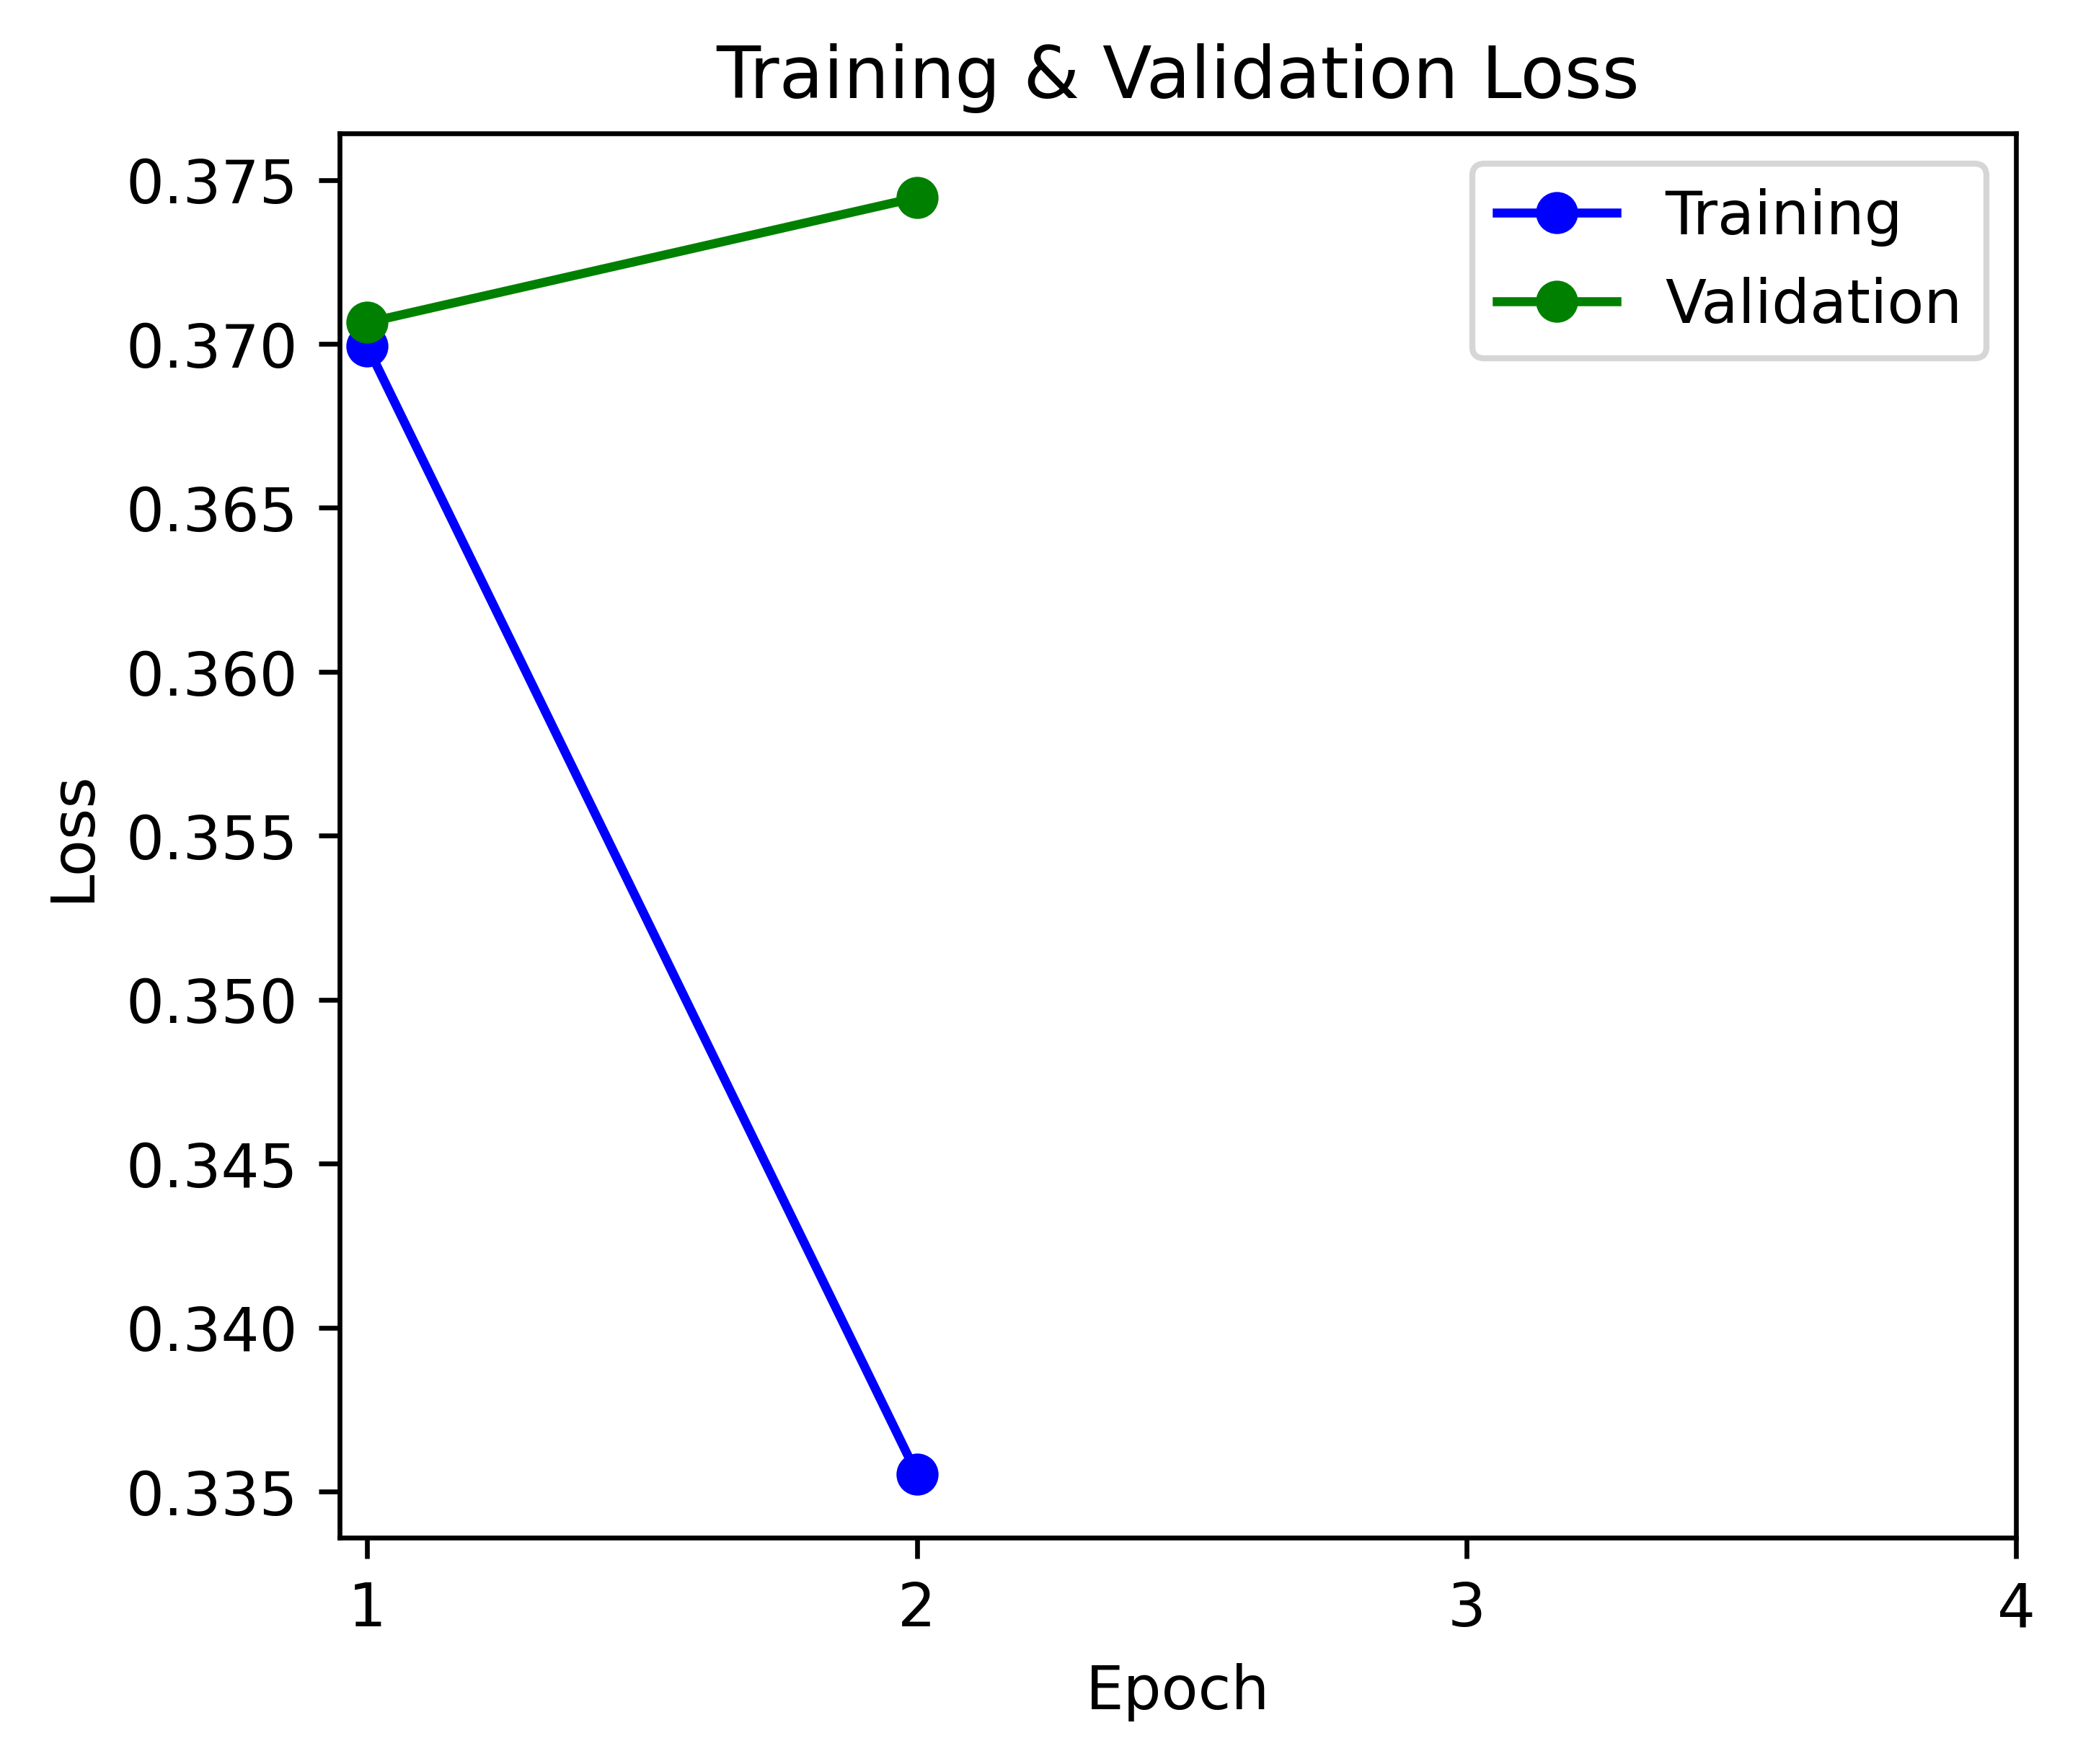

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
plt.rcParams['figure.dpi'] = 600 
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.figsize'] = (5, 4.3)


plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.savefig(result_path + 'train_val_loss.png')

plt.show()

In [ ]:

import os


output_dir = result_path + 'model_save/'


if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)


model_to_save = model.module if hasattr(model, 'module') else model 
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))
del output_dir

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """

    model.eval()

    all_logits = []
    all_labels = []
    all_patient_ids = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        # b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        patient_ids = batch[3].to(device)
        # Compute logits
        with torch.no_grad():
            # logits = model(b_input_ids, b_attn_mask)
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = output.loss
            logits = output.logits
        all_logits.append(logits)
        all_labels.append(b_labels)
        all_patient_ids.append(patient_ids)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_patient_ids = torch.cat(all_patient_ids, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    all_labels = all_labels.cpu().numpy()
    all_patient_ids = all_patient_ids.cpu().numpy()

    # data_need
    data_need = {}
    data_need = {'probs':probs, 'all_labels':all_labels, 'all_patient_ids':all_patient_ids}

    return data_need

In [ ]:
result_train, result_val, result_test, result_temp = {}, {}, {}, {} 
result_val = bert_predict(model, validation_dataloader)
result_test = bert_predict(model, test_dataloader)
result_temp = bert_predict(model, temp_dataloader)

In [ ]:
result_test['probs'][:5,:]

In [ ]:
import json

result_all_save = {}
result_all_save = {'train': {'probs': result_train['probs'].tolist(), 'all_labels': result_train['all_labels'].tolist(), \
                'all_patient_ids': result_train['all_patient_ids'].tolist()}, \
           'val': {'probs': result_val['probs'].tolist(), 'all_labels': result_val['all_labels'].tolist(), \
                'all_patient_ids': result_val['all_patient_ids'].tolist()}, \
           'test': {'probs': result_test['probs'].tolist(), 'all_labels': result_test['all_labels'].tolist(), \
                'all_patient_ids': result_test['all_patient_ids'].tolist()}, \
           'temp': {'probs': result_temp['probs'].tolist(), 'all_labels': result_temp['all_labels'].tolist(), \
                'all_patient_ids': result_temp['all_patient_ids'].tolist()}
          }

with open(result_path + 'text_all.json', 'w') as fp:
  json.dump(result_all_save, fp)

# with open(result_path + text_all.json', 'r') as fp:
#     result_all_save = json.load(fp)

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
evaluate_roc(result_train['probs'], result_train['all_labels'])

In [ ]:
evaluate_roc(result_val['probs'], result_val['all_labels'])

In [ ]:
evaluate_roc(result_test['probs'], result_test['all_labels'])

In [ ]:
evaluate_roc(result_temp['probs'], result_temp['all_labels'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, average_precision_score
from sklearn.metrics import brier_score_loss

def model_performance_params(data, data_pred_proba, ts_use, ts_value):
    """
    data: the truth label of target [array]
    data_pred_proba: predict probability of target with one columns [array]
    ts_use: 'True' or 'False' (if true, will use ts_value, else will not use ts_value) [Bool]
    ts_value: float value (if ts_use = 'True', will use it - input the value needed, or not use it)

    """
    fpr, tpr, thresholds_ROC = roc_curve(data, data_pred_proba)
    precision, recall, thresholds = precision_recall_curve(data, data_pred_proba)
    average_precision = average_precision_score(data, data_pred_proba)
    brier_score = brier_score_loss(data, data_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)

    threshold_final = []
    if ts_use == 'False':
        optimal_idx = []
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds_ROC[optimal_idx]
        sensitivity = tpr[optimal_idx]
        specificity = 1 - fpr[optimal_idx]
        data_pred = np.zeros(len(data_pred_proba))
        data_pred[data_pred_proba >= optimal_threshold] = 1
        threshold_final = optimal_threshold
    else:
        optimal_idx = []
        optimal_idx = np.max(np.where(thresholds_ROC >= ts_value))
        sensitivity = tpr[optimal_idx]
        specificity = 1 - fpr[optimal_idx]
        data_pred = np.zeros(len(data_pred_proba))
        data_pred[data_pred_proba >= ts_value] = 1
        threshold_final = ts_value

    tn, fp, fn, tp = confusion_matrix(data, data_pred).ravel()
    accuracy = accuracy_score(data, data_pred)
    F1 = f1_score(data, data_pred)  # not consider the imbalance, using 'binary' 2tp/(2tp+fp+fn)
    precision_c = tp/(tp+fp)

    parameters = {'auc': roc_auc, 'sensitivity': sensitivity, 'specificity': specificity, 'accuracy': accuracy,
                  'F1': F1, 'precision': precision_c, 'ap':average_precision, 'brier_score': brier_score, 'threshold': threshold_final}
    roc_plot_data = {'fpr_data': fpr, 'tpr_data': tpr}
    return parameters, roc_plot_data

In [ ]:


result_train_db = pd.DataFrame()
result_train_db[['probs_0','probs_1']] = result_train['probs']
result_train_db['all_labels'] = result_train['all_labels']
result_train_db['all_patient_ids'] = result_train['all_patient_ids']
result_train_db = result_train_db.groupby('all_patient_ids').agg({'probs_0':'mean', 'probs_1':'mean', 'all_labels':'max'})
result_train_db = result_train_db.reset_index(level=['all_patient_ids'])
result_train_db['db_type'] = 'train'

result_val_db = pd.DataFrame()
result_val_db[['probs_0','probs_1']] = result_val['probs']
result_val_db['all_labels'] = result_val['all_labels']
result_val_db['all_patient_ids'] = result_val['all_patient_ids']
result_val_db = result_val_db.groupby('all_patient_ids').agg({'probs_0':'mean', 'probs_1':'mean', 'all_labels':'max'})
result_val_db = result_val_db.reset_index(level=['all_patient_ids'])
result_val_db['db_type'] = 'val'

result_test_db = pd.DataFrame()
result_test_db[['probs_0','probs_1']] = result_test['probs']
result_test_db['all_labels'] = result_test['all_labels']
result_test_db['all_patient_ids'] = result_test['all_patient_ids']
result_test_db = result_test_db.groupby('all_patient_ids').agg({'probs_0':'mean', 'probs_1':'mean', 'all_labels':'max'})
result_test_db = result_test_db.reset_index(level=['all_patient_ids'])
result_test_db['db_type'] = 'test'

result_temp_db = pd.DataFrame()
result_temp_db[['probs_0','probs_1']] = result_temp['probs']
result_temp_db['all_labels'] = result_temp['all_labels']
result_temp_db['all_patient_ids'] = result_temp['all_patient_ids']
result_temp_db = result_temp_db.groupby('all_patient_ids').agg({'probs_0':'mean', 'probs_1':'mean', 'all_labels':'max'})
result_temp_db = result_temp_db.reset_index(level=['all_patient_ids'])
result_temp_db['db_type'] = 'temp'

result_all_db = pd.DataFrame()
result_all_db = pd.concat([result_train_db, result_val_db, result_test_db, result_temp_db], ignore_index=True)
result_all_db.to_csv(result_path + 'text_all.csv', index=False)

result_all_db.head(5)

In [ ]:
# save performance metric
result_train, result_val, result_test, result_temp = [], [], [], []
para, roc_plot = model_performance_params(result_train_db['all_labels'], result_train_db['probs_1'], 'False', 0)
result_train = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
        round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
        round(para['brier_score'],3), para['threshold'], 'train']

para, roc_plot = model_performance_params(result_val_db['all_labels'], result_val_db['probs_1'], 'False', 0)
result_val = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
        round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
        round(para['brier_score'],3), para['threshold'], 'val']

para, roc_plot = model_performance_params(result_test_db['all_labels'], result_test_db['probs_1'], 'False', 0)
result_test = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
        round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
        round(para['brier_score'],3), para['threshold'], 'test']

para, roc_plot = model_performance_params(result_temp_db['all_labels'], result_temp_db['probs_1'], 'False', 0)
result_temp = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
        round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
        round(para['brier_score'],3), para['threshold'], 'temp']

result_all = pd.DataFrame()
result_all = pd.DataFrame([result_train, result_val, result_test, result_temp], \
              columns=['auc', 'sensitivity', 'specificity', 'accuracy', 'F1', \
                  'precision', 'ap', 'brier_score', 'threshold', 'db_type']
              )
result_all.to_csv(result_path + 'text_metrics.csv', index=False)
print(result_all)

del result_train, result_val, result_test, result_temp

# **Part2. Machine learning combining text and numeric data**

## **1. Logistic regression model**

In [ ]:

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

def diff_data_type(data_initial, needing_type, outcome_name):
    # get different needing training and test data
    #     1.  type1 -- fit to regression model : LR, SVM      #
    if needing_type == 1:
        data_type1 = pd.DataFrame()
        X_type1, y_type1 = pd.DataFrame(), pd.DataFrame()

        data_type1 = data_initial
        names_dummies = ['activity_bed', 'activity_eva_flag', 'activity_sit', 'activity_stand', 
        'admission_type', 'bilirubin_max_flag', 'code_status', 'delirium_flag', 'delirium_eva_flag', 
        'dobutamine', 'dopamine', 'epinephrine', 'gender', 'norepinephrine', 'code_status_eva_flag',
        'pao2fio2ratio_novent_flag', 'vent', 'albumin_min_flag', 'vasopressor',
        'alp_max_flag', 'alt_max_flag', 'ast_max_flag', 'baseexcess_min_flag', 'fio2_max_flag',
        'lactate_max_flag', 'lymphocytes_max_flag', 'lymphocytes_min_flag', 'magnesium_max_flag',
        'neutrophils_min_flag', 'paco2_max_flag', 'pao2_min_flag', 'pao2fio2ratio_vent_flag', 'ptt_max_flag', 'nlr_flag']
        # 'fall_risk', 'fall_risk_eva_flag',

        for i in range(len(names_dummies)):
            vars()['dummies_' + names_dummies[i]] = pd.get_dummies(data_type1[names_dummies[i]],
                                                                   prefix=names_dummies[i])
            
            data_type1 = pd.concat([data_type1, vars()['dummies_' + names_dummies[i]]], axis=1)
            del vars()['dummies_' + names_dummies[i]]
        # data_type_new.drop(names_dummies, axis=1, inplace=True)
        data_type1.drop(names_dummies, axis=1, inplace=True)
        X_type1 = data_type1.drop([outcome_name, 'id'], axis=1)  # type1 features
        X_type1 = X_type1.reindex(sorted(X_type1.columns), axis=1)  # sort features name
        y_type1 = data_type1[[outcome_name, 'id']]  # type1 target
        X_train, X_test_all, y_train, y_test_all = train_test_split(X_type1, y_type1, test_size=0.2, random_state=0, shuffle=True)
        X_cal, X_test, y_cal, y_test = train_test_split(X_test_all, y_test_all, test_size=0.5, random_state=0, shuffle=True)
        min_max_scaler = preprocessing.MinMaxScaler()
        X_train = pd.DataFrame(min_max_scaler.fit_transform(X_train))
        X_cal = pd.DataFrame(min_max_scaler.fit_transform(X_cal))
        X_test = pd.DataFrame(min_max_scaler.fit_transform(X_test))
        X_train.columns = X_type1.columns
        X_cal.columns = X_type1.columns
        X_test.columns = X_type1.columns

        columns_name,X,y,data_need = [], pd.DataFrame(), pd.Series(), pd.DataFrame()
        columns_name = X_train.columns.values.tolist()
        X = X_train[columns_name].append(X_cal[columns_name]).append(X_test[columns_name]).reset_index(drop=True)
        y = y_train.append(y_cal).append(y_test).reset_index(drop=True)
        data_need = X
        data_need[['label','id']] = y


    else:
        #      2.  type2 -- fit to tree model: Xgboost, RF, DF      #
        data_type2 = pd.DataFrame()
        X_type2, y_type2 = pd.DataFrame(), pd.DataFrame()
        data_type2 = data_initial
        X_type2 = data_type2.drop(outcome_name, axis=1)  # type1 features
        X_type2 = X_type2.reindex(sorted(X_type2.columns), axis=1)  # sort features name
        y_type2 = data_type2[outcome_name]
        X_train, X_test_all, y_train, y_test_all = train_test_split(X_type2, y_type2, test_size=0.2, random_state=0, shuffle=True)
        X_cal, X_test, y_cal, y_test = train_test_split(X_test_all, y_test_all, test_size=0.5, random_state=0, shuffle=True)

        columns_name,X,y,data_need = [], pd.DataFrame(), pd.Series(), pd.DataFrame()
        columns_name = X_train.columns.values.tolist()
        X = X_train[columns_name].append(X_cal[columns_name]).append(X_test[columns_name]).reset_index(drop=True)
        y = y_train.append(y_cal).append(y_test).reset_index(drop=True)
        data_need = X
        data_need['label'] = y
    

    return data_need

In [ ]:

df_development, df_temporal, df_num, df_text = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

df_development = pd.read_csv(path+'data/seq_'+str(para_all['seq_len'])+'/development_num_older.csv')
df_temporal = pd.read_csv(path+'data/seq_'+str(para_all['seq_len'])+'/temporal_num_older.csv')
df_num = df_development.append(df_temporal).reset_index(drop=True)
df_num.drop(['first_careunit', 'ethnicity', 'anchor_year_group'], axis=1, inplace=True)
id_info = pd.read_csv(result_path + 'id_info.csv') # id: [train, val, test, temp]

result_all_db = pd.DataFrame()
result_all_db = pd.read_csv(result_path + 'text_all.csv')

result_train_db = result_all_db.loc[result_all_db['db_type'] == 'train'].reset_index(drop=True)
result_val_db = result_all_db.loc[result_all_db['db_type'] == 'val'].reset_index(drop=True)
result_test_db = result_all_db.loc[result_all_db['db_type'] == 'test'].reset_index(drop=True)
result_temp_db = result_all_db.loc[result_all_db['db_type'] == 'temp'].reset_index(drop=True)

df_text = result_train_db.append(result_val_db).append(result_test_db).append(result_temp_db).reset_index(drop=True)
df_text = df_text[['all_patient_ids', 'probs_1', 'all_labels']]
df_text = df_text.rename(columns={'all_patient_ids': 'id', 'probs_1': 'pre_adm_score', 'all_labels': 'label'})
del result_all_db, df_development, df_temporal, result_train_db, result_val_db, result_test_db, result_temp_db

# check
print('all numeric data: ', df_num.shape)
print('all text result data: ', df_text.shape)
print('id info: ', id_info.shape)

In [ ]:
print(df_num.head(5))
print(df_text.head(5))
print(id_info.head(5))
print(df_num.columns)

In [ ]:
df_num_type1 = pd.DataFrame()
df_num_type1 = diff_data_type(df_num, 1, 'label')
df_num_type1['id'] = df_num_type1['id'].astype('int64')
df_text['id'] = df_text['id'].astype('int64')
df_num_type1 = df_num_type1.merge(df_text[['id', 'pre_adm_score']], how='left', on='id')
df_num_type1.shape

In [ ]:
train_num_data, val_num_data, test_num_data, temp_num_data = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
train_num_data = df_num_type1[df_num_type1['id'].isin(list(id_info['train'].dropna(axis=0).astype('int64')))].reset_index(drop=True)
val_num_data = df_num_type1[df_num_type1['id'].isin(list(id_info['val'].dropna(axis=0).astype('int64')))].reset_index(drop=True)
test_num_data = df_num_type1[df_num_type1['id'].isin(list(id_info['test'].dropna(axis=0).astype('int64')))].reset_index(drop=True)
temp_num_data = df_num_type1[df_num_type1['id'].isin(list(id_info['temp'].dropna(axis=0).astype('int64')))].reset_index(drop=True)
print('train numeric data size: ', train_num_data.shape)
print('val numeric data size: ', val_num_data.shape)
print('test numeric data size: ', test_num_data.shape)
print('temp numeric data size: ', temp_num_data.shape)

In [ ]:
# train_num_data.columns.values.tolist()

In [ ]:
from sklearn.linear_model import LogisticRegression

no_need_cols_name = ['id', 'sofa', 'oasis', 'saps', 'apsiii', 'label', 'pre_adm_score']

predicted_LR = []
probas_LR = []
para_LR = {}
roc_plot_LR = {}
parameters = {}
fpr_LR, tpr_LR, threshold_LR = [], [], []
clf_LR_bs = LogisticRegression(multi_class="ovr", penalty="l1", class_weight="balanced", solver="liblinear")
re_LR_bs = clf_LR_bs.fit(train_num_data.drop(no_need_cols_name,axis=1), train_num_data['label'])
# re_LR_bs = CalibratedClassifierCV(re_LR_bs, method='isotonic', cv='prefit')
# re_LR_bs.fit(X_cal_type1, y_cal_type1)

In [ ]:
print('LR using numeric data in the val set:\n')
predicted_LR = re_LR_bs.predict(val_num_data.drop(no_need_cols_name,axis=1))
probas_LR = re_LR_bs.predict_proba(val_num_data.drop(no_need_cols_name,axis=1))
para, roc_plot = model_performance_params(val_num_data['label'], probas_LR[:, 1], 'False', 0)
result_val_num = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
          round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
          round(para['brier_score'],3), para['threshold'], 'val']
print(result_val_num)

print('LR using numeric data in the test set:\n')
predicted_LR = re_LR_bs.predict(test_num_data.drop(no_need_cols_name,axis=1))
probas_LR = re_LR_bs.predict_proba(test_num_data.drop(no_need_cols_name,axis=1))
para, roc_plot = model_performance_params(test_num_data['label'], probas_LR[:, 1], 'False', 0)
result_test_num = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
          round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
          round(para['brier_score'],3), para['threshold'], 'test']
print(result_test_num)

print('LR using numeric data in the temporal set:\n')
predicted_LR = re_LR_bs.predict(temp_num_data.drop(no_need_cols_name,axis=1))
probas_LR = re_LR_bs.predict_proba(temp_num_data.drop(no_need_cols_name,axis=1))
para, roc_plot = model_performance_params(temp_num_data['label'], probas_LR[:, 1], 'False', 0)
result_temp_num = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
          round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
          round(para['brier_score'],3), para['threshold'], 'temp']
print(result_temp_num)

result_all = pd.DataFrame()
result_all = pd.DataFrame([result_val_num, result_test_num, result_temp_num], \
              columns=['auc', 'sensitivity', 'specificity', 'accuracy', 'F1', \
                  'precision', 'ap', 'brier_score', 'threshold', 'db_type']
              )
result_all.to_csv(result_path + 'num_metrics.csv', index=False)
print(result_all)

del result_val_num, result_test_num, result_temp_num

## **2. Adding text info**

In [ ]:
from sklearn.linear_model import LogisticRegression

no_need_cols_name = ['id', 'sofa', 'oasis', 'saps', 'apsiii', 'label']

predicted_LR = []
probas_LR = []
para_LR = {}
roc_plot_LR = {}
parameters = {}
fpr_LR, tpr_LR, threshold_LR = [], [], []
clf_LR_bs = LogisticRegression(multi_class="ovr", penalty="l1", class_weight="balanced", solver="liblinear")
re_LR_bs = clf_LR_bs.fit(train_num_data.drop(no_need_cols_name,axis=1), train_num_data['label'])
# re_LR_bs = CalibratedClassifierCV(re_LR_bs, method='isotonic', cv='prefit')
# re_LR_bs.fit(X_cal_type1, y_cal_type1)

print('LR using numeric data in the val set:\n')
predicted_LR = re_LR_bs.predict(val_num_data.drop(no_need_cols_name,axis=1))
probas_LR = re_LR_bs.predict_proba(val_num_data.drop(no_need_cols_name,axis=1))
para, roc_plot = model_performance_params(val_num_data['label'], probas_LR[:, 1], 'False', 0)
result_val_num = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
          round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
          round(para['brier_score'],3), para['threshold'], 'val']
print(result_val_num)

print('LR using numeric data in the test set:\n')
predicted_LR = re_LR_bs.predict(test_num_data.drop(no_need_cols_name,axis=1))
probas_LR = re_LR_bs.predict_proba(test_num_data.drop(no_need_cols_name,axis=1))
para, roc_plot = model_performance_params(test_num_data['label'], probas_LR[:, 1], 'False', 0)
result_test_num = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
          round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
          round(para['brier_score'],3), para['threshold'], 'test']
print(result_test_num)

print('LR using numeric data in the temporal set:\n')
predicted_LR = re_LR_bs.predict(temp_num_data.drop(no_need_cols_name,axis=1))
probas_LR = re_LR_bs.predict_proba(temp_num_data.drop(no_need_cols_name,axis=1))
para, roc_plot = model_performance_params(temp_num_data['label'], probas_LR[:, 1], 'False', 0)
result_temp_num = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
          round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
          round(para['brier_score'],3), para['threshold'], 'temp']
print(result_temp_num)

result_all = pd.DataFrame()
result_all = pd.DataFrame([result_val_num, result_test_num, result_temp_num], \
              columns=['auc', 'sensitivity', 'specificity', 'accuracy', 'F1', \
                  'precision', 'ap', 'brier_score', 'threshold', 'db_type']
              )
result_all.to_csv(result_path + 'text_num_metrics.csv', index=False)
print(result_all)

del result_val_num, result_test_num, result_temp_num

## **3. acquire clinical scores**

In [ ]:
result_all = pd.DataFrame()

for score_name in ['sofa', 'oasis', 'saps', 'apsiii']:

  result_val_num, result_test_num, result_temp_num = [], [], []

  print('LR using numeric data in the val set:\n')
  para, roc_plot = model_performance_params(val_num_data['label'], val_num_data['apsiii'], 'False', 0)
  result_val_num = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
            round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
            round(para['brier_score'],3), para['threshold'], 'val', score_name]
  print(result_val_num)

  print('LR using numeric data in the test set:\n')
  para, roc_plot = model_performance_params(test_num_data['label'], test_num_data['apsiii'], 'False', 0)
  result_test_num = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
            round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
            round(para['brier_score'],3), para['threshold'], 'test', score_name]
  print(result_test_num)

  print('LR using numeric data in the temporal set:\n')
  para, roc_plot = model_performance_params(temp_num_data['label'], temp_num_data['apsiii'], 'False', 0)
  result_temp_num = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
            round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
            round(para['brier_score'],3), para['threshold'], 'temp', score_name]
  print(result_temp_num)
  
  result_all_each = pd.DataFrame()
  result_all_each = pd.DataFrame([result_val_num, result_test_num, result_temp_num], \
                columns=['auc', 'sensitivity', 'specificity', 'accuracy', 'F1', \
                    'precision', 'ap', 'brier_score', 'threshold', 'db_type', 'score']
                  )
  result_all = result_all.append(result_all_each)

result_all.to_csv(result_path + 'scores_metrics.csv', index=False)
print(result_all)

## **4. lasso L1 part of features performance**

In [ ]:
from sklearn.linear_model import LogisticRegression

no_need_cols_name = ['id', 'sofa', 'oasis', 'saps', 'apsiii', 'label', 'pre_adm_score']

predicted_LR = []
probas_LR = []
para_LR = {}
roc_plot_LR = {}
parameters = {}
fpr_LR, tpr_LR, threshold_LR = [], [], []
clf_LR_bs = LogisticRegression(multi_class="ovr", penalty="l1", class_weight="balanced", solver="liblinear")
re_LR_bs = clf_LR_bs.fit(train_num_data.drop(no_need_cols_name,axis=1), train_num_data['label'])

In [ ]:
import math
feature_names = train_num_data.drop(no_need_cols_name,axis=1).columns.values.tolist()
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
w = re_LR_bs.coef_[0]
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
feature_importance.reset_index(drop=True, inplace=True)
feature_importance.to_csv(result_path + 'num_l1_feature_ranking.csv', index=False)
ax = feature_importance.loc[:15,].plot.barh(x='feature', y='importance')

plt.savefig(result_path + 'num_l1_top15.png')

plt.show()

In [ ]:
list(feature_importance.loc[:6,'feature'])

In [ ]:
col_need = list(feature_importance.loc[:6,'feature']) + ['pre_adm_score']
predicted_LR = []
probas_LR = []
para_LR = {}
roc_plot_LR = {}
parameters = {}
fpr_LR, tpr_LR, threshold_LR = [], [], []
clf_LR_bs = LogisticRegression(multi_class="ovr", penalty="l1", class_weight="balanced", solver="liblinear")
re_LR_bs = clf_LR_bs.fit(train_num_data[col_need], train_num_data['label'])

In [ ]:
print('LR using numeric data in the val set:\n')
predicted_LR = re_LR_bs.predict(val_num_data[col_need])
probas_LR = re_LR_bs.predict_proba(val_num_data[col_need])
para, roc_plot = model_performance_params(val_num_data['label'], probas_LR[:, 1], 'False', 0)
result_val_num = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
          round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
          round(para['brier_score'],3), para['threshold'], 'val']
print(result_val_num)

print('LR using numeric data in the test set:\n')
predicted_LR = re_LR_bs.predict(test_num_data[col_need])
probas_LR = re_LR_bs.predict_proba(test_num_data[col_need])
para, roc_plot = model_performance_params(test_num_data['label'], probas_LR[:, 1], 'False', 0)
result_test_num = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
          round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
          round(para['brier_score'],3), para['threshold'], 'test']
print(result_test_num)

print('LR using numeric data in the temporal set:\n')
predicted_LR = re_LR_bs.predict(temp_num_data[col_need])
probas_LR = re_LR_bs.predict_proba(temp_num_data[col_need])
para, roc_plot = model_performance_params(temp_num_data['label'], probas_LR[:, 1], 'False', 0)
result_temp_num = [round(para['auc'],3), round(para['sensitivity'],3), round(para['specificity'],3), round(para['accuracy'],3),
          round(para['F1'],3), round(para['precision'],3), round(para['ap'],3), 
          round(para['brier_score'],3), para['threshold'], 'temp']
print(result_temp_num)

result_all = pd.DataFrame()
result_all = pd.DataFrame([result_val_num, result_test_num, result_temp_num], \
              columns=['auc', 'sensitivity', 'specificity', 'accuracy', 'F1', \
                  'precision', 'ap', 'brier_score', 'threshold', 'db_type']
              )
result_all.to_csv(result_path + 'text_num_part_metrics.csv', index=False)
print(result_all)

del result_val_num, result_test_num, result_temp_num